In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

import yaml
import time
import glob
import gc
# from memory_profiler import profile

In [2]:
%load_ext memory_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### download data

In [3]:
from transform_inputs import get_data

In [4]:
# %%memit
taus = get_data('data/ShuffleMergeSpectral_1.root', 'taus', step_size='1000 MB')
n_taus = len(taus)

In [5]:
tau_i = 7 # random tau index for illustrative purposes

In [6]:
# taus
# taus.fields

In [7]:
ak.num(taus.pfCand_pt), ak.num(taus.ele_pt), ak.num(taus.muon_pt)

(<Array [28, 31, 58, 28, 37, ... 54, 40, 42, 54] type='191700 * int64'>,
 <Array [0, 0, 0, 2, 0, 0, ... 0, 0, 0, 0, 1, 0] type='191700 * int64'>,
 <Array [1, 3, 3, 0, 1, 0, ... 0, 0, 1, 0, 0, 1] type='191700 * int64'>)

### define the grid

In [1]:
grid_types = ['inner', 'outer']
grid_dim = ['eta', 'phi']
grid_size, grid_left, grid_right = {}, {}, {}

In [2]:
n_cells = {'inner': 11, 'outer': 21}
cell_size = {'inner': 0.02, 'outer': 0.05}

In [10]:
for grid_type in grid_types:
    grid_size[grid_type] = cell_size[grid_type] * n_cells[grid_type]
    grid_left[grid_type], grid_right[grid_type] = - grid_size[grid_type] / 2, grid_size[grid_type] / 2

### derive constituents' features

In [11]:
from transform_inputs import add_vars_to_taus

In [12]:
constituent_types = ['ele', 'muon', 'pfCand']

In [13]:
# taus.fields

In [14]:
fill_branches = {'ele': ['ele_pt', 'ele_deta', 'ele_dphi', 'ele_mass',],
                 'muon': ['muon_pt', 'muon_deta', 'muon_dphi', 'muon_mass',],
                 'pfCand': [ 
                     'pfCand_jetDaughter',
                     'pfCand_tauSignal',
                     'pfCand_leadChargedHadrCand',
                     'pfCand_tauIso',
                     'pfCand_pt',
                     'pfCand_eta',
                     'pfCand_phi',
                     'pfCand_mass',
                     'pfCand_pvAssociationQuality',
                     'pfCand_fromPV',
                     'pfCand_puppiWeight',
                     'pfCand_puppiWeightNoLep',
                     'pfCand_pdgId',
                     'pfCand_charge',
                     'pfCand_lostInnerHits',
                     'pfCand_numberOfPixelHits',
                     'pfCand_numberOfHits',
                     'pfCand_vertex_x',
                     'pfCand_vertex_y',
                     'pfCand_vertex_z',
                     'pfCand_vertex_t',
                     'pfCand_time',
                     'pfCand_timeError',
                     'pfCand_hasTrackDetails',
                     'pfCand_dxy',
                     'pfCand_dxy_error',
                     'pfCand_dz',
                     'pfCand_dz_error',
                     'pfCand_track_chi2',
                     'pfCand_track_ndof',
                     'pfCand_caloFraction',
                     'pfCand_hcalFraction',
                     'pfCand_rawCaloFraction',
                     'pfCand_rawHcalFraction',]
                 
                 } # branches to be stored

In [15]:
# more features to be put here

In [16]:
# %%timeit
for c_type in constituent_types: 
    add_vars_to_taus(taus, c_type)

In [17]:
taus[tau_i]['n_ele'],  taus[tau_i]['n_muon'], taus[tau_i]['n_pfCand'],

(0, 0, 55)

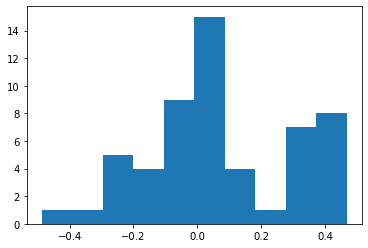

In [18]:
plt.hist(taus[tau_i].pfCand_deta)
plt.show()

### derive inner/outer grid masks

In [19]:
from transform_inputs import derive_grid_mask

In [20]:
# grid masks placeholder
grid_mask_dict = {key: {} for key in grid_types}

In [21]:
# %%timeit
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_mask_dict[grid_type][c_type] = derive_grid_mask(taus, c_type, grid_type)
    taus[f'inner_grid_{c_type}_mask'] = grid_mask_dict['inner'][c_type]
    taus[f'outer_grid_{c_type}_mask'] = grid_mask_dict['outer'][c_type] * (~grid_mask_dict['inner'][c_type])

In [22]:
for c_type in constituent_types:  
    for grid_type in grid_types:
        print(f'{c_type}: total {sum(taus[f"{grid_type}_grid_{c_type}_mask"][tau_i])} constituents in the {grid_type} cone for tau with i={tau_i}')
    print()

ele: total 0 constituents in the inner cone for tau with i=7
ele: total 0 constituents in the outer cone for tau with i=7

muon: total 0 constituents in the inner cone for tau with i=7
muon: total 0 constituents in the outer cone for tau with i=7

pfCand: total 13 constituents in the inner cone for tau with i=7
pfCand: total 42 constituents in the outer cone for tau with i=7



In [23]:
print(15*'*')
for c_type in constituent_types: 
    print()
    for grid_type in grid_types:  
        grid_mask = taus[f"{grid_type}_grid_{c_type}_mask"]
        print(f'{c_type}: total count of constituents per tau in the {grid_type} cone\n{ak.sum(grid_mask, axis=1)}')
        print()
    print(15*'*')

***************

ele: total count of constituents per tau in the inner cone
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

ele: total count of constituents per tau in the outer cone
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

muon: total count of constituents per tau in the inner cone
[1, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ... 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]

muon: total count of constituents per tau in the outer cone
[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

pfCand: total count of constituents per tau in the inner cone
[1, 5, 14, 1, 3, 18, 3, 13, 1, 15, 2, 2, ... 5, 2, 7, 4, 13, 9, 9, 11, 10, 6, 3, 6]

pfCand: total count of constituents per tau in the outer cone
[27, 26, 44, 27, 34, 28, 28, 42, 27, 61, ... 24, 35, 40, 45, 36, 31, 44, 34, 39, 48]

***************


### derive cell indices 

In [24]:
from transform_inputs import derive_cell_indices

In [25]:
# %%timeit
for c_type in constituent_types: 
    for grid_type in grid_types:
        for dim in grid_dim:
            taus[f'{grid_type}_grid_{c_type}_indices_{dim}'] = derive_cell_indices(taus, c_type, grid_type, dim)

In [26]:
print(15*'*')
for c_type in constituent_types: 
    for grid_type in grid_types:      
        grid_mask = taus[f"{grid_type}_grid_{c_type}_mask"]
        print()
        print(f'{c_type}: eta indices of constituents for tau with i={tau_i} in the {grid_type} cone\n{taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i]}')
    print(15*'*')

***************

ele: eta indices of constituents for tau with i=7 in the inner cone
[]

ele: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

muon: eta indices of constituents for tau with i=7 in the inner cone
[]

muon: eta indices of constituents for tau with i=7 in the outer cone
[]
***************

pfCand: eta indices of constituents for tau with i=7 in the inner cone
[5, 8, 6, 5, 5, 5, 5, 4, 4, 3, 0, 7, 9]

pfCand: eta indices of constituents for tau with i=7 in the outer cone
[15, 12, 9, 5, 10, 10, 12, 10, 18, 19, 16, ... 16, 13, 12, 11, 10, 10, 7, 6, 5, 3]
***************


### validating indices

In [27]:
grid_type = 'outer'
c_type = 'pfCand'
tau_i = 10

In [28]:
grid_mask = taus[f'{grid_type}_grid_{c_type}_mask']
grid_coord = ak.to_pandas(taus[[f'{c_type}_deta', f'{c_type}_dphi', ]][grid_mask][tau_i])
grid_coord

,pfCand_deta,pfCand_dphi
entry,,
0,0.448764,-0.175213
1,0.486302,-0.060366
2,-0.096724,-0.242806
3,0.156519,0.374124
4,0.202663,-0.382540
5,-0.104415,0.112392
6,-0.258228,0.230261
7,0.000508,-0.485674
8,0.218593,0.333297


In [29]:
eta_indices = taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[f"{grid_type}_grid_{c_type}_indices_phi"][grid_mask][tau_i].tolist()
for i,j in zip(eta_indices, phi_indices):
    print(i,j)

19.0 6.0
20.0 9.0
8.0 5.0
13.0 17.0
14.0 2.0
8.0 12.0
5.0 15.0
10.0 0.0
14.0 17.0
14.0 18.0
11.0 16.0
7.0 13.0


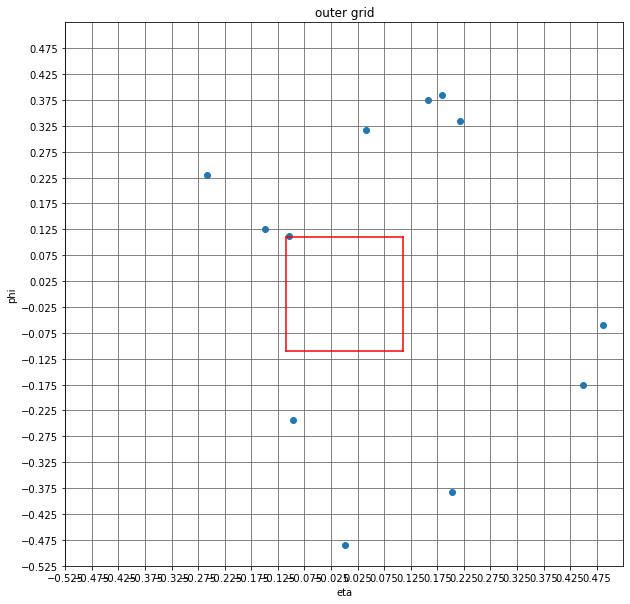

In [30]:
fig, ax = plt.subplots(1, figsize=(10, 10))

if grid_type != 'inner':
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_right['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_left['inner']], [grid_left['inner'], grid_right['inner']], 'r')
    ax.plot([grid_left['inner'], grid_right['inner']], [grid_left['inner'], grid_left['inner']], 'r')
    ax.plot([grid_right['inner'], grid_right['inner']], [grid_left['inner'], grid_right['inner']], 'r')

ax.scatter(x=grid_coord[f'{c_type}_deta'], y=grid_coord[f'{c_type}_dphi'])

ax.set_xlim(grid_left[grid_type], grid_right[grid_type])
ax.set_ylim(grid_left[grid_type], grid_right[grid_type])
ax.set_xticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))
ax.set_yticks(np.arange(grid_left[grid_type], grid_right[grid_type], cell_size[grid_type]))

ax.set_xlabel('eta')
ax.set_ylabel('phi')
ax.set_title(f'{grid_type} grid')

plt.grid(b=True, which='major', color='#666666', linestyle='-') 

plt.show()

### fill final tensor

In [31]:
from transform_inputs import get_grid_mask, get_fill_indices, get_fill_values

In [56]:
taus.fields

['run',
 'lumi',
 'evt',
 'npv',
 'rho',
 'genEventWeight',
 'trainingWeight',
 'sampleType',
 'tauType',
 'dataset_id',
 'dataset_group_id',
 'npu',
 'pv_x',
 'pv_y',
 'pv_z',
 'pv_t',
 'pv_xE',
 'pv_yE',
 'pv_zE',
 'pv_tE',
 'pv_chi2',
 'pv_ndof',
 'jet_index',
 'jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_mass',
 'jet_neutralHadronEnergyFraction',
 'jet_neutralEmEnergyFraction',
 'jet_nConstituents',
 'jet_chargedMultiplicity',
 'jet_neutralMultiplicity',
 'jet_partonFlavour',
 'jet_hadronFlavour',
 'jet_has_gen_match',
 'jet_gen_pt',
 'jet_gen_eta',
 'jet_gen_phi',
 'jet_gen_mass',
 'jet_gen_n_b',
 'jet_gen_n_c',
 'jetTauMatch',
 'tau_index',
 'tau_pt',
 'tau_eta',
 'tau_phi',
 'tau_mass',
 'tau_charge',
 'lepton_gen_match',
 'lepton_gen_charge',
 'lepton_gen_pt',
 'lepton_gen_eta',
 'lepton_gen_phi',
 'lepton_gen_mass',
 'lepton_gen_firstCopy_pt',
 'lepton_gen_firstCopy_eta',
 'lepton_gen_firstCopy_phi',
 'lepton_gen_firstCopy_mass',
 'lepton_gen_vis_pdg',
 'lepton_gen_vis_pt',
 'lepto

In [32]:
fill_branches = {'ele': ['ele_pt', 'ele_deta', 'ele_dphi', 'ele_mass',
                        ],
                 'muon': ['muon_pt', 'muon_deta', 'muon_dphi', 'muon_mass',
                         ],
                 'pfCand': [ 
                     'pfCand_jetDaughter',
                     'pfCand_tauSignal',
                     'pfCand_leadChargedHadrCand',
                     'pfCand_tauIso',
#                      'pfCand_pt',
#                      'pfCand_eta',
#                      'pfCand_phi',
#                      'pfCand_mass',
#                      'pfCand_pvAssociationQuality',
#                      'pfCand_fromPV',
#                      'pfCand_puppiWeight',
#                      'pfCand_puppiWeightNoLep',
#                      'pfCand_pdgId',
#                      'pfCand_charge',
#                      'pfCand_lostInnerHits',
#                      'pfCand_numberOfPixelHits',
#                      'pfCand_numberOfHits',
#                      'pfCand_vertex_x',
#                      'pfCand_vertex_y',
#                      'pfCand_vertex_z',
#                      'pfCand_vertex_t',
#                      'pfCand_time',
#                      'pfCand_timeError',
#                      'pfCand_hasTrackDetails',
#                      'pfCand_dxy',
#                      'pfCand_dxy_error',
#                      'pfCand_dz',
#                      'pfCand_dz_error',
#                      'pfCand_track_chi2',
#                      'pfCand_track_ndof',
#                      'pfCand_caloFraction',
#                      'pfCand_hcalFraction',
#                      'pfCand_rawCaloFraction',
#                      'pfCand_rawHcalFraction',
                 ]
                 
                 } # branches to be stored

In [33]:
# initialize tensors to be filled 
grid_tensors = {key: {} for key in grid_types}
for c_type in constituent_types:
    for grid_type in grid_types:
        grid_tensors[grid_type][c_type] = np.zeros((n_taus, n_cells[grid_type], n_cells[grid_type], len(fill_branches[c_type])))

In [34]:
# override limit with this value
n_taus = 1000 

In [35]:
# dictionaries to store timing
get_mask_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
get_fill_indices_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
get_fill_values_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}
fill_tensor_times = {key: {c_key: [] for c_key in constituent_types} for key in grid_types}

program_starts = time.time()
for i_tau, tau in enumerate(taus):
    if i_tau%10 == 0:
        print(f'---> processing {i_tau}th tau')
    if i_tau == n_taus:
        break
    for c_type in constituent_types:
        for grid_type in grid_types:        
            begin_iter = time.time()
            # get mask
            grid_mask = get_grid_mask(tau, c_type, grid_type)
            if ak.sum(grid_mask) == 0:
                continue
            after_get_mask = time.time()
            get_mask_times[grid_type][c_type].append(after_get_mask - begin_iter)

            # get indices
            indices_eta, indices_phi = get_fill_indices(tau, c_type, grid_type, grid_mask)
            after_get_fill_indices = time.time()
            get_fill_indices_times[grid_type][c_type].append(after_get_fill_indices - after_get_mask)

            # get values
#             values_to_fill = get_fill_values(tau, fill_branches[c_type], grid_mask)
            values_to_fill = np.ones((len(indices_eta), len(fill_branches[c_type])))
            after_get_fill_values = time.time()
            get_fill_values_times[grid_type][c_type].append(after_get_fill_values - after_get_fill_indices)

            # put them in the tensor
            grid_tensors[grid_type][c_type][i_tau, indices_eta, indices_phi, :] = values_to_fill
            after_put = time.time()
            fill_tensor_times[grid_type][c_type].append(after_put - after_get_fill_values)       
program_ends = time.time()

---> processing 0th tau
---> processing 10th tau
---> processing 20th tau
---> processing 30th tau
---> processing 40th tau
---> processing 50th tau
---> processing 60th tau
---> processing 70th tau
---> processing 80th tau
---> processing 90th tau
---> processing 100th tau
---> processing 110th tau
---> processing 120th tau
---> processing 130th tau
---> processing 140th tau
---> processing 150th tau
---> processing 160th tau
---> processing 170th tau
---> processing 180th tau
---> processing 190th tau
---> processing 200th tau
---> processing 210th tau
---> processing 220th tau
---> processing 230th tau
---> processing 240th tau
---> processing 250th tau
---> processing 260th tau
---> processing 270th tau
---> processing 280th tau
---> processing 290th tau
---> processing 300th tau
---> processing 310th tau
---> processing 320th tau
---> processing 330th tau
---> processing 340th tau
---> processing 350th tau
---> processing 360th tau
---> processing 370th tau
---> processing 380th t

In [36]:
# # release memory
#     for grid_type in grid_types:
#         del grid_tensors[grid_type]
# gc.collect()

In [37]:
print(f'Processed {n_taus} taus in {program_ends - program_starts} seconds\n')
for c_type in constituent_types:
    print(f'=== {c_type}\n')
    for grid_type in grid_types:
        print(f'------- {grid_type} cell')
        print(f'median get_grid_mask() time: {np.median(get_mask_times[grid_type][c_type])}')
        print(f'median get_fill_indices() time: {np.median(get_fill_indices_times[grid_type][c_type])}')
        print(f'median get_fill_values() time: {np.median(get_fill_values_times[grid_type][c_type])}')
        print(f'median fill tensor time: {np.median(fill_tensor_times[grid_type][c_type])}')
        print()
    print()

Processed 1000 taus in 2.0884931087493896 seconds

=== ele

------- inner cell
median get_grid_mask() time: 5.3882598876953125e-05
median get_fill_indices() time: 0.00040721893310546875
median get_fill_values() time: 8.106231689453125e-06
median fill tensor time: 0.0001671314239501953

------- outer cell
median get_grid_mask() time: 5.3882598876953125e-05
median get_fill_indices() time: 0.00041103363037109375
median get_fill_values() time: 8.344650268554688e-06
median fill tensor time: 0.00016891956329345703


=== muon

------- inner cell
median get_grid_mask() time: 4.696846008300781e-05
median get_fill_indices() time: 0.0004062652587890625
median get_fill_values() time: 8.106231689453125e-06
median fill tensor time: 0.0001666545867919922

------- outer cell
median get_grid_mask() time: 5.53131103515625e-05
median get_fill_indices() time: 0.00040650367736816406
median get_fill_values() time: 8.106231689453125e-06
median fill tensor time: 0.0001672506332397461


=== pfCand

------- inn

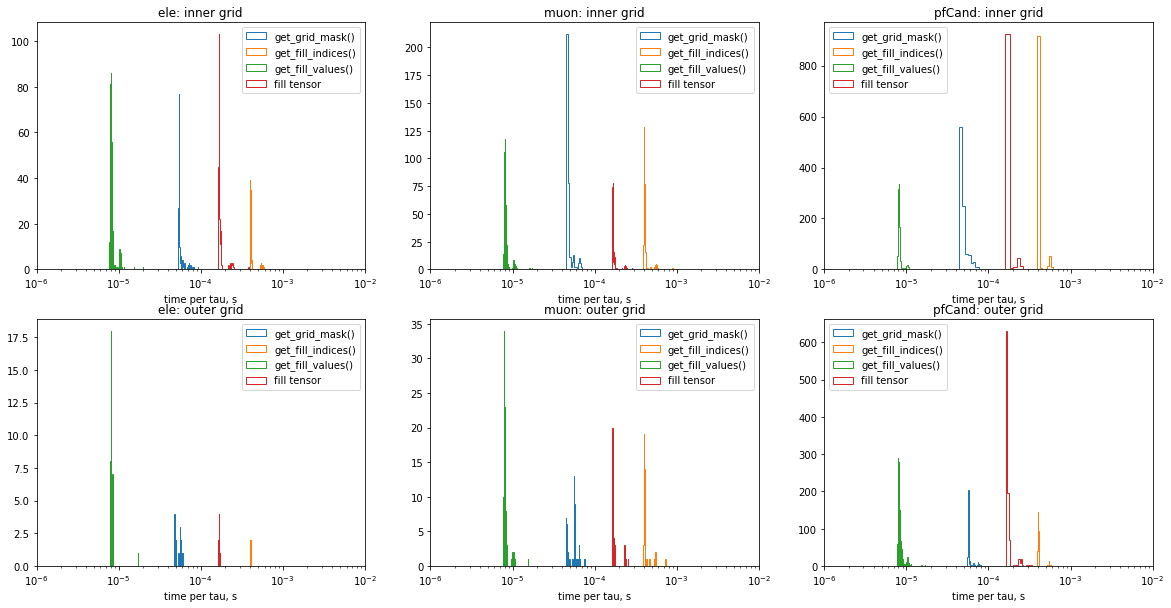

In [161]:
f, ax = plt.subplots(len(grid_types), len(constituent_types), figsize=(20,10))
for i, grid_type in enumerate(grid_types):
    for j, c_type in enumerate(constituent_types):
        ax[i,j].hist(get_mask_times[grid_type][c_type], histtype='step', bins=100, label='get_grid_mask()')
        ax[i,j].hist(get_fill_indices_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_indices()')
        ax[i,j].hist(get_fill_values_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_values()')
        ax[i,j].hist(fill_tensor_times[grid_type][c_type], histtype='step', bins=100, label='fill tensor')
        ax[i,j].set_xlabel('time per tau, s')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim((1e-6, 1e-2))
        ax[i,j].set_title(f'{c_type}: {grid_type} grid')
        ax[i,j].legend()

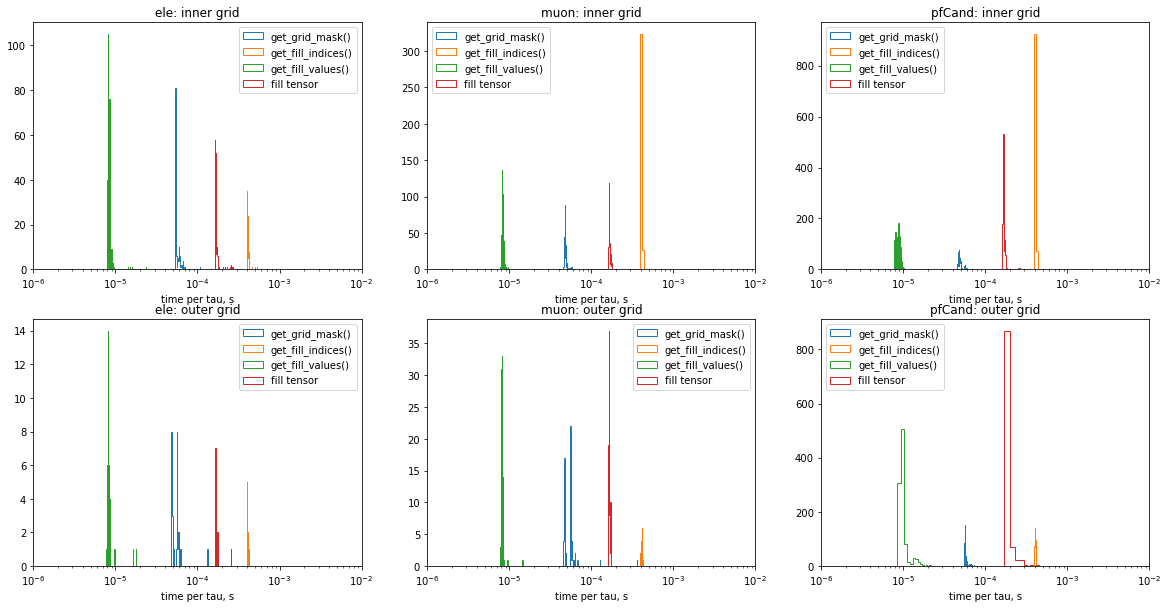

In [172]:
f, ax = plt.subplots(len(grid_types), len(constituent_types), figsize=(20,10))
for i, grid_type in enumerate(grid_types):
    for j, c_type in enumerate(constituent_types):
        ax[i,j].hist(get_mask_times[grid_type][c_type], histtype='step', bins=100, label='get_grid_mask()')
        ax[i,j].hist(get_fill_indices_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_indices()')
        ax[i,j].hist(get_fill_values_times[grid_type][c_type], histtype='step', bins=100, label='get_fill_values()')
        ax[i,j].hist(fill_tensor_times[grid_type][c_type], histtype='step', bins=100, label='fill tensor')
        ax[i,j].set_xlabel('time per tau, s')
        ax[i,j].set_xscale('log')
        ax[i,j].set_xlim((1e-6, 1e-2))
        ax[i,j].set_title(f'{c_type}: {grid_type} grid')
        ax[i,j].legend()

### validating final tensor

In [200]:
grid_type = 'inner'
c_type = 'pfCand'
tau_i = 10

In [201]:
grid_mask = taus[f'{grid_type}_grid_{c_type}_mask']
grid_coord = ak.to_pandas(taus[[f'{c_type}_deta', f'{c_type}_dphi', ]][grid_mask][tau_i])
grid_coord

,pfCand_deta,pfCand_dphi
entry,,
0,-0.063398,0.010041
1,0.076316,-0.012617


In [202]:
feature_i = 2

In [51]:
eta_indices = taus[f"{grid_type}_grid_{c_type}_indices_eta"][grid_mask][tau_i].tolist()
phi_indices = taus[f"{grid_type}_grid_{c_type}_indices_phi"][grid_mask][tau_i].tolist()
vals = taus[fill_branches[c_type][feature_i]][grid_mask][tau_i]
for x,y,v in sorted(zip(eta_indices, phi_indices, vals)):
    print(x,y,v)

2.0 6.0 0.010040640830993652
9.0 4.0 -0.012616664171218872


In [52]:
nonzero_idx_eta = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 0]
nonzero_idx_phi = np.argwhere(grid_tensors[grid_type][c_type][tau_i, :, :, feature_i])[:, 1]
nonzero_vals = grid_tensors[grid_type][c_type][tau_i, nonzero_idx_eta, nonzero_idx_phi, feature_i]
for x,y,v in sorted(zip(nonzero_idx_eta, nonzero_idx_phi, nonzero_vals)):
    print(x,y,v)

2 6 0.010040640830993652
9 4 -0.012616664171218872
